In [38]:
from ultralytics import YOLO

from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt


import numpy as np
from numpy import asarray
from PIL import Image
import cv2


from shapely.geometry import Polygon
import torch
from torchvision.ops import box_iou
from stockfish import Stockfish

from PIL import Image, ImageDraw
import supervision as sv
from stockfish import StockfishException
from threading import Thread


In [39]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [40]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [41]:
def intersection_area(box_1, box_2):
    # Calculate the intersection area of two rectangles
    x_overlap = max(0, min(box_1[2][0], box_2[2][0]) - max(box_1[0][0], box_2[0][0]))
    y_overlap = max(0, min(box_1[2][1], box_2[2][1]) - max(box_1[0][1], box_2[0][1]))
    return x_overlap * y_overlap
    
def polygon_area(vertices):
    # Calculate the area of a polygon using the shoelace formula
    area = 0
    for i in range(len(vertices)):
        j = (i + 1) % len(vertices)
        area += vertices[i][0] * vertices[j][1]
        area -= vertices[j][0] * vertices[i][1]
    return abs(area) / 2

def calculate_iou(box_1, box_2):

    area_box_1 = polygon_area(box_1)
    area_box_2 = polygon_area(box_2)
    intersection_area_val = intersection_area(box_1, box_2)
    union_area = area_box_1 + area_box_2 - intersection_area_val
    iou = intersection_area_val / union_area if union_area != 0 else 0.0
    return iou

In [42]:
def detect_corners(image):
    
    model_trained = YOLO("corners.pt")
    results = model_trained.predict(source=image, conf=0.5, augment=False,save=False)

    # get the corners coordinates from the model
    boxes = results[0].boxes
    arr = boxes.xywh.numpy()
    points = arr[:,0:2]
    
    corners = order_points(points)
    
    return corners  

In [43]:
def four_point_transform(image, pts):

    try:
        image = Image.open(image)
    except:
        pass
    img = asarray(image)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Calculate the width and height of the new image
    maxWidth = max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl))
    maxHeight = max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl))

    # Define the destination points
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (int(maxWidth), int(maxHeight)))

    # Convert the warped image back to Image format
    warped_img = Image.fromarray(warped)

    return warped_img, M

In [44]:
# Function to interpolate points
def interpolate(xy0, xy1):
    x0, y0 = xy0
    x1, y1 = xy1
    dx = (x1 - x0) / 8
    dy = (y1 - y0) / 8
    pts = [(x0 + i * dx, y0 + i * dy) for i in range(9)]
    return pts
    
def plot_grid_on_transformed_image(image,plot=False):
    # Define corners of the image
    corners = np.array([[0, 0],
                        [image.size[0], 0],
                        [0, image.size[1]],
                        [image.size[0], image.size[1]]])
    corners = order_points(corners)



    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]



    # Interpolate points for grid lines
    pts_top = interpolate(TL, TR)
    pts_left = interpolate(TL, BL)
    pts_right = interpolate(TR, BR)
    pts_bottom = interpolate(BL, BR)


    if plot:
        figure(figsize=(10, 10), dpi=80)
        implot = plt.imshow(image)
        # Plot grid lines
        for a, b in zip(pts_left, pts_right):
            plt.plot([a[0], b[0]], [a[1], b[1]], linestyle="--", color='red', marker='o', markersize=5)
        
        for a, b in zip(pts_top, pts_bottom):
            plt.plot([a[0], b[0]], [a[1], b[1]], linestyle="--", color='red', marker='o', markersize=5)
    
        plt.axis('off')
    
        plt.savefig('chessboard_transformed_with_grid.jpeg')
    return pts_top, pts_left


In [45]:
# Declare global variables
h8, g8, f8, e8, d8, c8, b8, a8 = None, None, None, None, None, None, None, None
h7, g7, f7, e7, d7, c7, b7, a7 = None, None, None, None, None, None, None, None
h6, g6, f6, e6, d6, c6, b6, a6 = None, None, None, None, None, None, None, None
h5, g5, f5, e5, d5, c5, b5, a5 = None, None, None, None, None, None, None, None
h4, g4, f4, e4, d4, c4, b4, a4 = None, None, None, None, None, None, None, None
h3, g3, f3, e3, d3, c3, b3, a3 = None, None, None, None, None, None, None, None
h2, g2, f2, e2, d2, c2, b2, a2 = None, None, None, None, None, None, None, None
h1, g1, f1, e1, d1, c1, b1, a1 = None, None, None, None, None, None, None, None

def vect2fen(ptsT,ptsL):
    global h8, g8, f8, e8, d8, c8, b8, a8
    global h7, g7, f7, e7, d7, c7, b7, a7
    global h6, g6, f6, e6, d6, c6, b6, a6
    global h5, g5, f5, e5, d5, c5, b5, a5
    global h4, g4, f4, e4, d4, c4, b4, a4
    global h3, g3, f3, e3, d3, c3, b3, a3
    global h2, g2, f2, e2, d2, c2, b2, a2
    global h1, g1, f1, e1, d1, c1, b1, a1
    #calculate the grid

    xA = ptsT[0][0]
    xB = ptsT[1][0]
    xC = ptsT[2][0]
    xD = ptsT[3][0]
    xE = ptsT[4][0]
    xF = ptsT[5][0]
    xG = ptsT[6][0]
    xH = ptsT[7][0]
    xI = ptsT[8][0]
    
    y9 = ptsL[0][1]
    y8 = ptsL[1][1] 
    y7 = ptsL[2][1] 
    y6 = ptsL[3][1]  
    y5 = ptsL[4][1]  
    y4 = ptsL[5][1] 
    y3 = ptsL[6][1]  
    y2 = ptsL[7][1] 
    y1 = ptsL[8][1] 
    
    #calculate all the squares
    
    h8 = np.array([[xA,y9], [xB, y9], [xB, y8], [xA, y8]])
    g8 = np.array([[xA,y8], [xB, y8], [xB, y7], [xA, y7]])
    f8 = np.array([[xA,y7], [xB, y7], [xB, y6], [xA, y6]])
    e8 = np.array([[xA,y6], [xB, y6], [xB, y5], [xA, y5]])
    d8 = np.array([[xA,y5], [xB, y5], [xB, y4], [xA, y4]])
    c8 = np.array([[xA,y4], [xB, y4], [xB, y3], [xA, y3]])
    b8 = np.array([[xA,y3], [xB, y3], [xB, y2], [xA, y2]])
    a8 = np.array([[xA,y2], [xB, y2], [xB, y1], [xA, y1]])
    
    h7 = np.array([[xB,y9], [xC, y9], [xC, y8], [xB, y8]])
    g7 = np.array([[xB,y8], [xC, y8], [xC, y7], [xB, y7]])
    f7 = np.array([[xB,y7], [xC, y7], [xC, y6], [xB, y6]])
    e7 = np.array([[xB,y6], [xC, y6], [xC, y5], [xB, y5]])
    d7 = np.array([[xB,y5], [xC, y5], [xC, y4], [xB, y4]])
    c7 = np.array([[xB,y4], [xC, y4], [xC, y3], [xB, y3]])
    b7 = np.array([[xB,y3], [xC, y3], [xC, y2], [xB, y2]])
    a7 = np.array([[xB,y2], [xC, y2], [xC, y1], [xB, y1]])
    
    h6 = np.array([[xC,y9], [xD, y9], [xD, y8], [xC, y8]])
    g6 = np.array([[xC,y8], [xD, y8], [xD, y7], [xC, y7]])
    f6 = np.array([[xC,y7], [xD, y7], [xD, y6], [xC, y6]])
    e6 = np.array([[xC,y6], [xD, y6], [xD, y5], [xC, y5]])
    d6 = np.array([[xC,y5], [xD, y5], [xD, y4], [xC, y4]])
    c6 = np.array([[xC,y4], [xD, y4], [xD, y3], [xC, y3]])
    b6 = np.array([[xC,y3], [xD, y3], [xD, y2], [xC, y2]])
    a6 = np.array([[xC,y2], [xD, y2], [xD, y1], [xC, y1]])
    
    h5 = np.array([[xD,y9], [xE, y9], [xE, y8], [xD, y8]])
    g5 = np.array([[xD,y8], [xE, y8], [xE, y7], [xD, y7]])
    f5 = np.array([[xD,y7], [xE, y7], [xE, y6], [xD, y6]])
    e5 = np.array([[xD,y6], [xE, y6], [xE, y5], [xD, y5]])
    d5 = np.array([[xD,y5], [xE, y5], [xE, y4], [xD, y4]])
    c5 = np.array([[xD,y4], [xE, y4], [xE, y3], [xD, y3]])
    b5 = np.array([[xD,y3], [xE, y3], [xE, y2], [xD, y2]])
    a5 = np.array([[xD,y2], [xE, y2], [xE, y1], [xD, y1]])
    
    h4 = np.array([[xE,y9], [xF, y9], [xF, y8], [xE, y8]])
    g4 = np.array([[xE,y8], [xF, y8], [xF, y7], [xE, y7]])
    f4 = np.array([[xE,y7], [xF, y7], [xF, y6], [xE, y6]])
    e4 = np.array([[xE,y6], [xF, y6], [xF, y5], [xE, y5]])
    d4 = np.array([[xE,y5], [xF, y5], [xF, y4], [xE, y4]])
    c4 = np.array([[xE,y4], [xF, y4], [xF, y3], [xE, y3]])
    b4 = np.array([[xE,y3], [xF, y3], [xF, y2], [xE, y2]])
    a4 = np.array([[xE,y2], [xF, y2], [xF, y1], [xE, y1]])
    
    h3 = np.array([[xF,y9], [xG, y9], [xG, y8], [xF, y8]])
    g3 = np.array([[xF,y8], [xG, y8], [xG, y7], [xF, y7]])
    f3 = np.array([[xF,y7], [xG, y7], [xG, y6], [xF, y6]])
    e3 = np.array([[xF,y6], [xG, y6], [xG, y5], [xF, y5]])
    d3 = np.array([[xF,y5], [xG, y5], [xG, y4], [xF, y4]])
    c3 = np.array([[xF,y4], [xG, y4], [xG, y3], [xF, y3]])
    b3 = np.array([[xF,y3], [xG, y3], [xG, y2], [xF, y2]])
    a3 = np.array([[xF,y2], [xG, y2], [xG, y1], [xF, y1]])
    
    h2 = np.array([[xG,y9], [xH, y9], [xH, y8], [xG, y8]])
    g2 = np.array([[xG,y8], [xH, y8], [xH, y7], [xG, y7]])
    f2 = np.array([[xG,y7], [xH, y7], [xH, y6], [xG, y6]])
    e2 = np.array([[xG,y6], [xH, y6], [xH, y5], [xG, y5]])
    d2 = np.array([[xG,y5], [xH, y5], [xH, y4], [xG, y4]])
    c2 = np.array([[xG,y4], [xH, y4], [xH, y3], [xG, y3]])
    b2 = np.array([[xG,y3], [xH, y3], [xH, y2], [xG, y2]])
    a2 = np.array([[xG,y2], [xH, y2], [xH, y1], [xG, y1]])
    
    h1 = np.array([[xH,y9], [xI, y9], [xI, y8], [xH, y8]])
    g1 = np.array([[xH,y8], [xI, y8], [xI, y7], [xH, y7]])
    f1 = np.array([[xH,y7], [xI, y7], [xI, y6], [xH, y6]])
    e1 = np.array([[xH,y6], [xI, y6], [xI, y5], [xH, y5]])
    d1 = np.array([[xH,y5], [xI, y5], [xI, y4], [xH, y4]])
    c1 = np.array([[xH,y4], [xI, y4], [xI, y3], [xH, y3]])
    b1 = np.array([[xH,y3], [xI, y3], [xI, y2], [xH, y2]])
    a1 = np.array([[xH,y2], [xI, y2], [xI, y1], [xH, y1]])
    
    # transforms the squares to write FEN
    
    FEN_annotation = [[h8, h7, h6, h5, h4, h3, h2, h1],
                      [g8, g7, g6, g5, g4, g3, g2, g1],
                      [f8, f7, f6, f5, f4, f3, f2, f1],
                      [e8, e7, e6, e5, e4, e3, e2, e1],
                      [d8, d7, d6, d5, d4, d3, d2, d1],
                      [c8, c7, c6, c5, c4, c3, c2, c1],
                      [b8, b7, b6, b5, b4, b3, b2, b1],
                      [a8, a7, a6, a5, a4, a3, a2, a1]]
    
    return FEN_annotation

In [46]:
# detects chess pieces

def chess_pieces_detector(image):
    
    model_trained = YOLO("4-30/best.pt")
    results = model_trained.predict(source=image, conf=0.6,save=False)
    
    boxes = results[0].boxes
    detections = boxes.xyxy.numpy()
    
    return detections, boxes

In [47]:
import numpy as np

def connect_square_to_detection(detections, square, boxes):
    di = {0: 'b', 1: 'k', 2: 'n',
          3: 'p', 4: 'q', 5: 'r', 
          6: 'B', 7: 'K', 8: 'N',
          9: 'P', 10: 'Q', 11: 'R'}

    list_of_iou = []

    for box in detections:
        box_xmin, box_ymin, box_xmax, box_ymax = box
        
        # transform high pieces
        a=min(box_ymax - box_ymin,box_xmax - box_xmin)
        if box_ymax - box_ymin > box_xmax - box_xmin:
            box_ymin =box_ymax- a*(2/3)
        else:
            box_xmin =box_xmax- a*(2/3)
            
        
        box_complete = np.array([[box_xmin, box_ymin], [box_xmax, box_ymin], [box_xmax, box_ymax], [box_xmin, box_ymax]])

        list_of_iou.append(calculate_iou(box_complete, square))

    max_iou = max(list_of_iou, default=0)
    if max_iou > 0.25:
        piece_idx = list_of_iou.index(max_iou)
        return di[boxes.cls[piece_idx].tolist()]
    else:
        return "empty"

In [48]:
%%time
# Initialize Stockfish engine
#stockfish = Stockfish(path="C:\\Users\\MOUAD\\Desktop\\Data science\\Chess_object_detection\\stockfish\\stockfish-windows-x86-64-avx2.exe",
#                     parameters={"Threads":4})
def best_move(FEN):
    stockfish = Stockfish(path="C:\\Users\\MOUAD\\Desktop\\Data science\\Chess_object_detection\\stockfish\\stockfish-windows-x86-64-avx2.exe",
                     parameters={"Threads":4})
    #stockfish.set_depth(depth)
    stockfish.set_fen_position(FEN)
    return stockfish.get_best_move(), stockfish.get_evaluation()['value']
best_move("r3k3/ppp3p1/2np3r/4p2p/3bP2B/5R1B/1P3PPP/2R3K1 b")

CPU times: total: 93.8 ms
Wall time: 704 ms


('d4b6', -213)

In [49]:
%%time
#from stockfish import Stockfish


VALUE_MATE = 32000


def mate_to_value(mate: int) -> int:
    """
    Convert mate number to value.
    """
    if mate > 0:
        v = VALUE_MATE - 2*mate + 1
    else:
        v = -VALUE_MATE - 2*mate

    return v


def my_get_evaluation( fen: str, timems=10):
    """
    Evaluate the fen with fish at a given timems.
    Returns a dict of score {'cp': '49', 'mate': None} and move.
    """
    
    fish = Stockfish(r'C:\\Users\\MOUAD\\Desktop\\Data science\\Chess_object_detection\\stockfish\\stockfish-windows-x86-64-avx2.exe')
    score = {}
    bestmove = '0000'

    fish.set_fen_position(fen)
    fish.get_best_move_time(timems)

    search_info = fish.info
    bestmove = search_info.split(' pv ')[1].split()[0]

    if 'score cp ' in search_info:
        score_cp = search_info.split('score cp ')[1].split()[0]
        score.update({'cp': int(score_cp), 'mate': None})
    elif 'score mate ' in search_info:
        score_mate = search_info.split('score mate ')[1].split()[0]
        score_cp = mate_to_value(int(score_mate))
        score.update({'cp': int(score_cp), 'mate': int(score_mate)})

    return bestmove, score['cp'] 

fish = Stockfish(r'C:\\Users\\MOUAD\\Desktop\\Data science\\Chess_object_detection\\stockfish\\stockfish-windows-x86-64-avx2.exe')
fen="r3k3/ppp3p1/2np3r/4p2p/3bP2B/5R1B/1P3PPP/2R3K1 b - - 0 1"
timems=10
bm,score = my_get_evaluation(fen)
bm,score

CPU times: total: 62.5 ms
Wall time: 656 ms


('d4b2', 173)

In [50]:
def move2squares(move):
    square1=move[:2]
    square2=move[2:]
    return eval(square1), eval(square2)

In [51]:
def winning_probability(cp):
    """
    Use a sigmoid or logistic function to map the engine score cp into [0 to 1] winning probability.
    Technically winning probability is like score rate because the game of chess has draw results.
    So winning probability is like (num_wins + num_draw/2)/total_games.

    cp is a score in centipawn unit.

    Ref: https://www.chessprogramming.org/Pawn_Advantage,_Win_Percentage,_and_Elo
    """
    # K is a factor to scale the winning probability, if K is low the winning probability is high.
    # Stronger engine generally has a lower K value that is if stronger engine has an advantage of
    # 75 centipawn, while a weaker engine has an advantage of 75 centipawn too, it is the stronger
    # engine that has a higher chance to win the game.
    K = 4  

    p = cp/100  # convert centipawn to pawn unit

    return 1 / (1 + 10 ** (-p/K))

In [52]:
import cv2
import numpy as np

#original_img = cv2.imread('board6.jpg')

#box1_warped0 = np.array([[141, 0],
#                         [282, 0],
#                         [282, 122.75],
#                         [141, 122.75]])

#box2_warped0 = np.array([[282, 245.5],
#                         [423, 245.5],
#                         [423, 368.25],
#                         [282, 368.25]])

def colorBoxes(original_img, box1_warped, box2_warped, cp, M):
    try:
        original_img = cv2.imread(original_img)
    except:
        pass  
        
    # Convert the coordinates to homogeneous form
    box1_warped_homogeneous = np.hstack((box1_warped, np.ones((4, 1))))
    box2_warped_homogeneous = np.hstack((box2_warped, np.ones((4, 1))))
    
    # Calculate the inverse of the transformation matrix 'M'
    M_inverse = np.linalg.inv(M)
    
    # Apply the inverse transformation matrix to the coordinates of each box
    box1_original_homogeneous = np.dot(M_inverse, box1_warped_homogeneous.T).T
    box2_original_homogeneous = np.dot(M_inverse, box2_warped_homogeneous.T).T
    
    # Convert the coordinates back to Cartesian form
    box1_original = box1_original_homogeneous[:, :2] / box1_original_homogeneous[:, 2:]
    box2_original = box2_original_homogeneous[:, :2] / box2_original_homogeneous[:, 2:]
    
    # Draw rectangles on the original image using the transformed coordinates
    color = (0, 255, 0)  # Green color for the rectangles
    
    # Draw rectangles on the original image for box1 and box2
    mask_boxes = np.zeros_like(original_img)
    cv2.fillPoly(mask_boxes, [np.int32(box1_original)], color)
    cv2.fillPoly(mask_boxes, [np.int32(box2_original)], color)
    

    mask_score = np.zeros_like(original_img)

    img_height = original_img.shape[0]

    a=0.03
    b=0.03
    c=0.07
    
    rect1 = (int(a * img_height), int(b* img_height))
    rect2 = (int((1-winning_probability(cp)) * img_height), int(c * img_height))
    rect3 = (rect2[0], rect1[1])
    rect4 = (int(img_height - a * img_height), rect2[1])


    cv2.rectangle(mask_score, rect1, rect2, (0,0,0), thickness=cv2.FILLED)
    cv2.rectangle(mask_score, rect3, rect4, (100,100,100), thickness=cv2.FILLED)
    cv2.rectangle(mask_score, rect1, rect4, (150,150,150), thickness=3)

    text = f"{cp/100}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_color = (255, 255, 255)  # White color in BGR
    thickness = 2
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    text_position = (int(rect2[0]-0.04 * img_height), int(rect2[1] + text_size[1] + 0.015 * img_height))
    #cv2.putText(original_img, text, (rect2_end[0]+10,rect2_end[1]), font, font_scale, (0,0,0), thickness+3)
    
    mask_score_text = np.zeros_like(original_img)
    cv2.putText(mask_score_text, text, text_position, font, font_scale, font_color, thickness)

    result=np.zeros_like(original_img)
    
    result = cv2.addWeighted(result, 1, mask_score, 1, 0)
    result = cv2.addWeighted(result, 1, mask_score_text, 1, 0)
    result = cv2.addWeighted(result, 1, original_img, 1, 0)
    result = cv2.addWeighted(result, 1, mask_boxes, 0.5, 0)

    result=cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

#plt.imshow(colorBoxes(original_img, box1_warped, box2_warped, -200, M))
#colorBoxes(original_img, box1_warped, box2_warped, -200, M)

In [53]:
def process_detections(detections):
    processed_boxes = []
    
    for box in detections:
        box_xmin, box_ymin, box_xmax, box_ymax = box
        
        a = min(box_ymax - box_ymin, box_xmax - box_xmin)
        if box_ymax - box_ymin > box_xmax - box_xmin:
            new_box_ymin = box_ymax - a
            processed_boxes.append([box_xmin, new_box_ymin, box_xmax, box_ymax])
        else:
            new_box_xmin = box_xmax - a 
            processed_boxes.append([new_box_xmin, box_ymin, box_xmax, box_ymax])
    
    return np.array(processed_boxes)


In [54]:
import numpy as np
import cv2

def transform_boxes(boxes, M, image):
    image_np = np.array(image)
    image_shape = image_np.shape[:2]
    transformed_boxes = []
    for box in boxes:
        # Convert box to list of points [x, y]
        points = np.array([[box[0], box[1]], [box[2], box[1]], [box[2], box[3]], [box[0], box[3]]], dtype=np.float32)
        points = np.expand_dims(points, axis=1)
        
        # Apply perspective transformation
        transformed_points = cv2.perspectiveTransform(points, M)
        
        transformed_points = np.maximum(transformed_points, 0)
        transformed_points[:, :, 0] = np.minimum(transformed_points[:, :, 0], image_shape[1])
        transformed_points[:, :, 1] = np.minimum(transformed_points[:, :, 1], image_shape[0])
        
        # Convert transformed points back to box format (xmin, ymin, xmax, ymax)
        xmin = np.min(transformed_points[:, :, 0])
        ymin = np.min(transformed_points[:, :, 1])
        xmax = np.max(transformed_points[:, :, 0])
        ymax = np.max(transformed_points[:, :, 1])
        
        transformed_boxes.append([xmin, ymin, xmax, ymax])
    #transformed_boxes=process_detections(transformed_boxes)
    return np.array(transformed_boxes)


In [55]:

def convert_to_fen(board):
    fen = ''
    for row in board.split('/'):
        count = 0
        for char in row:
            if char.isdigit():
                count += int(char)
            else:
                if count:
                    fen += str(count)
                    count = 0
                fen += char
        if count:
            fen += str(count)
        fen += '/'
    return fen[:-1]

def board_FEN(FEN_matrix,detections,boxes):
    board_FEN = []
    corrected_FEN = []
    complete_board_FEN = []
    
    
    for line in FEN_matrix:
        line_to_FEN = []
        for square in line:
            piece_on_square = connect_square_to_detection(detections, square,boxes)    
            line_to_FEN.append(piece_on_square)
        corrected_FEN = [i.replace('empty', '1') for i in line_to_FEN]
        print(corrected_FEN)
        board_FEN.append(corrected_FEN)
    
    
    complete_board_FEN = [''.join(line[::-1]) for line in [col for col in zip(*board_FEN)]]
    
    return convert_to_fen('/'.join(complete_board_FEN))

## Complete

In [56]:
def show_move(image,player='w',move=None,centipawn=None):
    try:
        image = cv2.imread(image)
    except:
        pass  # Continue to the next iteration if an error occurs
    image = cv2.resize(image, (640, 640))
    corners = detect_corners(image)
    
    transformed_image,M = four_point_transform(image, corners)
    
    ptsT, ptsL = plot_grid_on_transformed_image(transformed_image)
    
    detections, boxes = chess_pieces_detector(image)
    detections = transform_boxes(detections, M,transformed_image)
    
    FEN_matrix = vect2fen(ptsT,ptsL)
    
    
    to_FEN=board_FEN(FEN_matrix,detections,boxes)
    
    FEN=f"{to_FEN} {player}"
    print(FEN)
    if not move:
        move,centipawn=my_get_evaluation(FEN)#d4c3
    box1_warped,box2_warped=move2squares(move)
    
    image=colorBoxes(image,box1_warped,box2_warped,centipawn,M)
    
    return image,to_FEN,move,centipawn


0: 640x640 4 cornerss, 221.4ms
Speed: 8.9ms preprocess, 221.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 black-bishop, 1 black-king, 1 black-knight, 7 black-pawns, 2 black-rooks, 2 white-bishops, 1 white-king, 5 white-pawns, 2 white-rooks, 369.0ms
Speed: 5.0ms preprocess, 369.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
['1', '1', 'r', 'p', 'B', 'B', 'P', '1']
['1', 'p', '1', '1', '1', '1', 'P', 'K']
['1', '1', '1', '1', '1', 'R', 'P', '1']
['k', '1', '1', 'p', 'P', '1', '1', '1']
['1', '1', 'p', '1', 'b', '1', '1', '1']
['1', 'p', 'n', '1', '1', '1', '1', 'R']
['1', 'p', '1', '1', '1', '1', 'P', '1']
['r', 'p', '1', '1', '1', '1', '1', '1']
r3k3/ppp3p1/2np3r/4p2p/3bP2B/5R1B/1P3PPP/2R3K1 b


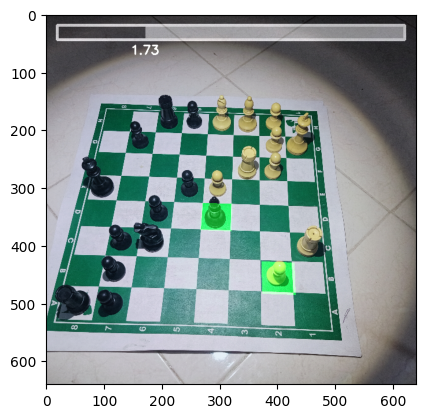

In [57]:
#res=show_move('board9.jpg',player='b')
#plt.imshow(res[0])

## Real time processing

In [36]:
import cv2
from PIL import Image

def real_time_processing(source=0, skip_frames=1):
    cap = cv2.VideoCapture(source)
    frame_counter = 0
    p = 0
    consecutive_exceptions = 0  
    last_state_exception = False

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (640, 640))
    player = ['b','w']
    move,centipawn=None,None
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_counter += 1

            if frame_counter % skip_frames != 0:
                continue
            
            
            
            try:
                if consecutive_exceptions >= 10 and last_state_exception:
                    p = (p + 1) % 2  
                    consecutive_exceptions = 

                
                processed_frame = show_move(frame, player[p],move,centipawn)[0]
                processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
                consecutive_exceptions = 0              
                last_state_exception = False
                
            except StockfishException:
                move,centipawn=None,None
                consecutive_exceptions += 1
                last_state_exception = True  # Set the flag
                processed_frame = frame
            print(consecutive_exceptions,last_state_exception,p)

            # Resize the image
            processed_frame = cv2.resize(processed_frame, (640, 640))

            # Write the frame into the output video
            out.write(processed_frame)
                        
            cv2.imshow('Processed Frame', processed_frame)

            # Check for keyboard input to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except KeyboardInterrupt:
        pass

    # Release the capture and video writer
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Call the main function with skip_frames parameter
real_time_processing(source="vidff.mp4", skip_frames=2)



0: 640x640 4 cornerss, 200.5ms
Speed: 4.0ms preprocess, 200.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 black-bishop, 1 black-king, 1 black-knight, 7 black-pawns, 2 black-rooks, 2 white-bishops, 1 white-king, 5 white-pawns, 2 white-rooks, 332.1ms
Speed: 4.9ms preprocess, 332.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
['1', '1', 'r', 'p', 'B', 'B', 'P', '1']
['1', 'p', '1', '1', '1', '1', 'P', 'K']
['1', '1', '1', '1', '1', 'R', 'P', '1']
['k', '1', '1', 'p', 'P', '1', '1', '1']
['1', '1', 'p', '1', 'b', '1', '1', '1']
['1', 'p', 'n', '1', '1', '1', '1', 'R']
['1', 'p', '1', '1', '1', '1', 'P', '1']
['r', 'p', '1', '1', '1', '1', '1', '1']
r3k3/ppp3p1/2np3r/4p2p/3bP2B/5R1B/1P3PPP/2R3K1 b
[0, 0] [False, False] 0

0: 640x640 4 cornerss, 242.4ms
Speed: 4.9ms preprocess, 242.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 black-bishop, 1 black-king, 1 black-knight, 7 black-pawns, 2 black-roo